### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from functions import *
from pprint import pprint
from sklearn.preprocessing import scale
%matplotlib inline

#### Importing Dataset

In [2]:
ls

'2019 County Health Rankings Data - v2.xls'*   marc_index.ipynb
 analytic_data2019.csv*                        Mod4_Project_README.md
 clean.csv                                     __pycache__/
 data_transform.ipynb                          README.md
 functions.py                                  shuyu_index.ipynb


### If the cleaning process has already been done jump to import the cleaned csv later in the file

In [3]:
xls = pd.ExcelFile('2019 County Health Rankings Data - v2.xls')
df = pd.read_excel(xls, 'Additional Measure Data',skiprows=1)

In [4]:
df.head()

,FIPS,State,County,Life Expectancy,95% CI - Low,95% CI - High,Life Expectancy (Black),Life Expectancy (Hispanic),Life Expectancy (White),# Deaths,...,% Hispanic,# Non-Hispanic White,% Non-Hispanic White,# Not Proficient in English,% Not Proficient in English,95% CI - Low.16,95% CI - High.16,% Female,# Rural,% Rural
0,1001,Alabama,Autauga,76.330589,75.554117,77.107061,74.600628,NaN,76.337219,815.0,...,2.857452,41336,74.473912,430,0.828548,0.422472,1.234624,51.342246,22921.0,42.002162
1,1003,Alabama,Baldwin,78.599498,78.208357,78.990639,75.628919,98.039893,78.537003,2827.0,...,4.550200,176582,83.047388,872,0.454512,0.282144,0.626880,51.452772,77060.0,42.279099
2,1005,Alabama,Barbour,75.779457,74.639355,76.919559,74.240228,NaN,77.568384,451.0,...,4.206569,11613,45.955679,297,1.199273,0.580536,1.818011,47.229917,18613.0,67.789635
3,1007,Alabama,Bibb,73.928271,72.624611,75.231931,72.294686,NaN,74.109510,445.0,...,2.638080,16842,74.298571,84,0.394348,0.000000,0.933361,46.453150,15663.0,68.352607
4,1009,Alabama,Blount,74.597767,73.810999,75.384535,NaN,78.577094,74.098247,1050.0,...,9.565097,50439,86.944306,1013,1.870004,1.364180,2.375829,50.688639,51562.0,89.951502


In [5]:
df.select_dtypes(include=['object'])[:2]

,State,County,Other PCP Ratio
0,Alabama,Autauga,3265:1
1,Alabama,Baldwin,1916:1


### Exploratory Data Analysis

#### Renaming columns

In [6]:
columns_name = df.columns
new_column_names = []
for column_name in columns_name:
    new_column_names.append(column_name.replace(" ", "_"))
pprint(new_column_names[:5])
df.columns = new_column_names

['FIPS', 'State', 'County', 'Life_Expectancy', '95%_CI_-_Low']


#### Renaming counties

In [7]:
county_names = df["County"]
new_county_names = []
for county_name in county_names:
    new_county_names.append(county_name.replace(" ", "_"))
df["County"] = new_county_names

#### Dropping ethnicies columns and columns with a lot of missing values

In [8]:
to_drop = ["Other_PCP_Ratio", "FIPS", "Segregation_index", "Segregation_Index" , "%_Free_or_Reduced_Lunch", "#_HIV_Cases", "HIV_Prevalence_Rate"]
#Data is missing for HIV only in South Dakota, replace it by country weighted average later or look at this column in depth
containing = ["CI_-_Low", "CI_-_High", "#_","White", "Hispanic", "Black", "Asian" ,"Alaskan", "Indian", "Hawaiian", "African"]
for column in df.columns:
    if (column in to_drop) or any(word in column for word in containing):
        df = df.drop([column], axis=1)

In [9]:
df.columns

Index(['State', 'County', 'Life_Expectancy', 'Age-Adjusted_Mortality',
       'Child_Mortality_Rate', 'Infant_Mortality_Rate',
       '%_Frequent_Physical_Distress', '%_Frequent_Mental_Distress',
       '%_Diabetic', '%_Food_Insecure', '%_Limited_Access',
       'Drug_Overdose_Mortality_Rate', 'MV_Mortality_Rate',
       '%_Insufficient_Sleep', '%_Uninsured', '%_Uninsured.1',
       'Other_PCP_Rate', '%_Disconnected_Youth', 'Household_Income',
       'Homicide_Rate', 'Firearm_Fatalities_Rate', '%_Homeowners',
       '%_Severe_Housing_Cost_Burden', 'Population', '%_<_18', '%_65_and_over',
       '%_Not_Proficient_in_English', '%_Female', '%_Rural'],
      dtype='object')

In [10]:
#Not necessary --> df["%_18_and_<_65"] = 100 - (df["%_<_18"] + df["%_65_and_over"])

In [11]:
ren_col = {"Household_Income": "Household_Median_Income",
           "%_Uninsured": "%_Uninsured_adults",
           "%_Uninsured.1" : "%_Uninsured_children",
           "%_Limited_Access": "%_Limited_Access_Healthy_Food"}

In [12]:
df.rename(columns=ren_col, inplace=True)

#### Delete rows missing Life Expectancy

In [13]:
df = df.dropna(subset=["Life_Expectancy"])

### Fill counties missing values using states weighted averages

In [14]:
df.head(2)

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099


#### Calculate the weighted averages for each columns in each states

In [15]:
states = list(df.State.unique())
columns = [x for x in list(df.columns) if x not in ["State", "County"]]

In [16]:
state_wv = {}
for state in states:
    df_state = df.loc[df["State"] == state]
    for column in columns:
        values = df_state.dropna(subset=[column])[column]
        population_value = df_state.dropna(subset=[column])["Population"].astype(np.float64)
        population = np.sum(df_state.dropna(subset=[column])["Population"])
        if population != 0:
            wv = (values * population_value).sum() / population
            if not state_wv.get(state):
                state_wv[state] = {}
            state_wv[state][column] = float(wv)
        else:
            print(f"No data for {column} in {state}")

#### Fill each missing values by states weighted averages

In [17]:
df_filled = df.copy()
for index in df.index:
    for column in df.columns:
        if column not in ["State","County"]:
            if np.isnan(df[column][index]):
                df_filled[column][index] = state_wv[df["State"][index]][column]

/home/locsta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
df_filled.head()

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099
2,Alabama,Barbour,75.779457,469.8,77.080027,8.444680,16.216160,14.632311,18.0,23.2,...,7.0,15.2,62.506800,13.586765,25270,20.763751,18.824693,1.199273,47.229917,67.789635
3,Alabama,Bibb,73.928271,563.7,111.749681,14.792899,13.162968,12.854036,14.9,15.8,...,8.2,21.3,75.361481,8.733889,22668,20.606141,16.022587,0.394348,46.453150,68.352607
4,Alabama,Blount,74.597767,501.8,76.032935,6.184688,13.720057,13.827943,14.3,11.0,...,7.4,19.7,78.521025,8.194495,58013,23.349939,17.842553,1.870004,50.688639,89.951502


#### Saving cleaned DataFrame to csv file

In [19]:
df_filled.to_csv(r"/home/locsta/Documents/FlatIron/County-Health-Analysis/clean.csv", index=False)

### Importing Cleaned CSV

In [2]:
df = pd.read_csv("clean.csv")
df.head()

,State,County,Life_Expectancy,Age-Adjusted_Mortality,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Physical_Distress,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,...,Homicide_Rate,Firearm_Fatalities_Rate,%_Homeowners,%_Severe_Housing_Cost_Burden,Population,%_<_18,%_65_and_over,%_Not_Proficient_in_English,%_Female,%_Rural
0,Alabama,Autauga,76.330589,438.7,53.279441,7.699275,12.824434,12.638357,14.2,13.4,...,5.2,17.7,73.287736,12.645206,55504,23.937014,15.119631,0.828548,51.342246,42.002162
1,Alabama,Baldwin,78.599498,348.4,47.000017,5.851337,12.622002,12.822558,11.3,12.3,...,2.9,14.4,72.859338,12.795922,212628,21.848487,19.947044,0.454512,51.452772,42.279099
2,Alabama,Barbour,75.779457,469.8,77.080027,8.444680,16.216160,14.632311,18.0,23.2,...,7.0,15.2,62.506800,13.586765,25270,20.763751,18.824693,1.199273,47.229917,67.789635
3,Alabama,Bibb,73.928271,563.7,111.749681,14.792899,13.162968,12.854036,14.9,15.8,...,8.2,21.3,75.361481,8.733889,22668,20.606141,16.022587,0.394348,46.453150,68.352607
4,Alabama,Blount,74.597767,501.8,76.032935,6.184688,13.720057,13.827943,14.3,11.0,...,7.4,19.7,78.521025,8.194495,58013,23.349939,17.842553,1.870004,50.688639,89.951502


In [4]:
df["%_Not_Proficient_in_English"] = df["%_Not_Proficient_in_English"].replace(0,0.01)
df["%_Not_Proficient_in_English"]

0       0.828548
1       0.454512
2       1.199273
3       0.394348
4       1.870004
5       1.104692
6       0.712702
7       0.880968
8       0.153894
9       0.097225
10      2.253253
11      0.001000
12      0.197773
13      0.447761
14      0.888920
15      1.258768
16      0.395257
17      0.001000
18      0.539415
19      0.418682
20      1.322428
21      0.819256
22      0.953516
23      0.091530
24      3.336571
25      0.759095
26      0.516570
27      1.199844
28      0.001000
29      4.886863
          ...   
3043    0.188134
3044    0.530920
3045    0.681241
3046    0.777972
3047    1.207803
3048    0.969479
3049    0.775004
3050    0.729765
3051    0.690459
3052    1.063494
3053    2.984157
3054    0.135788
3055    0.001000
3056    0.269664
3057    1.341176
3058    0.177620
3059    0.037170
3060    0.859924
3061    0.142499
3062    0.964085
3063    0.383305
3064    0.725579
3065    0.876872
3066    0.239960
3067    0.510150
3068    1.582845
3069    4.042033
3070    0.9113

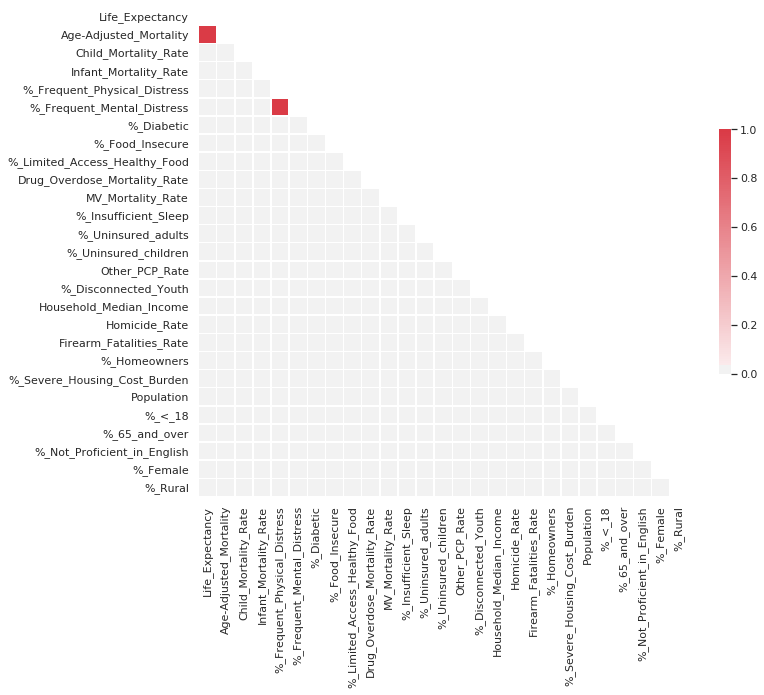

In [4]:
print_corr(df, 0.75)

# TODO Check for homoscedaticity and normality
https://github.com/learn-co-students/dsc-modeling-your-data-lab-london-ds-111819/tree/solution

#### Drop highly correlated columns and useless columns for modeling

In [4]:
useless = ["County", "Age-Adjusted_Mortality", "%_Frequent_Physical_Distress"]
for column in useless:
    df = df.drop([column], axis=1)

#### Plot variables distribution

/home/locsta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


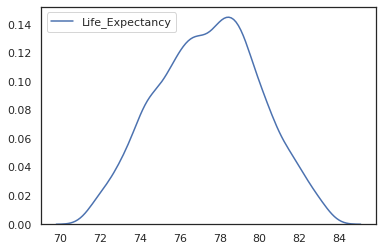

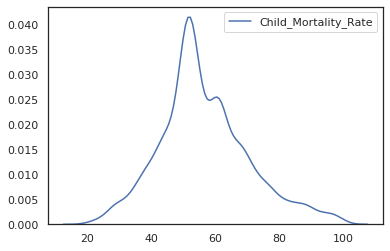

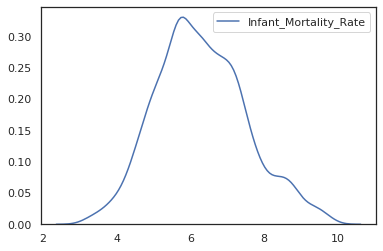

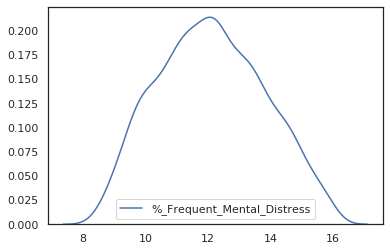

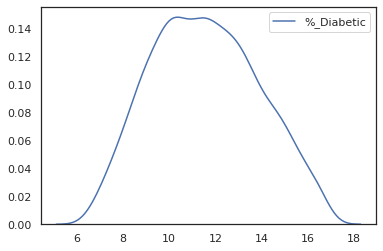

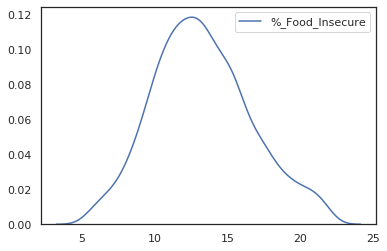

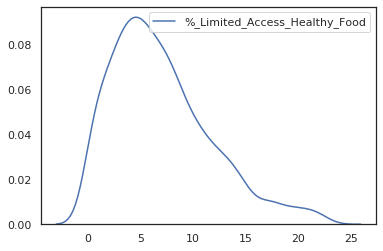

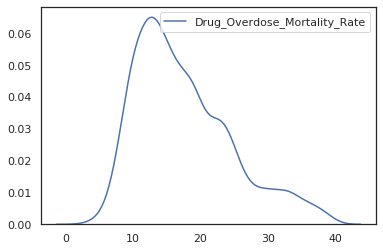

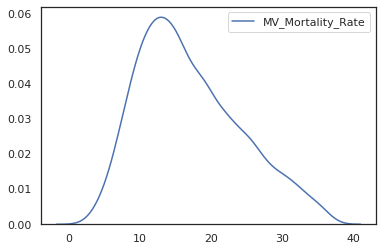

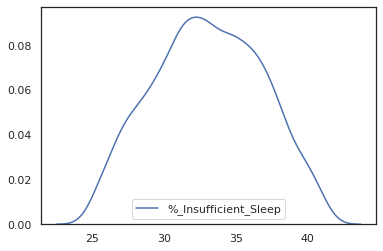

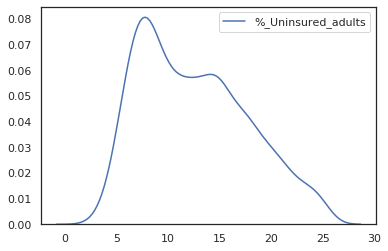

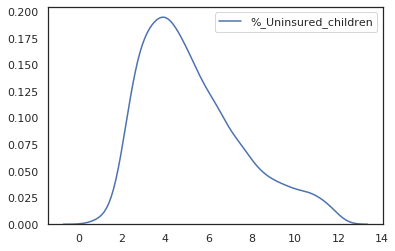

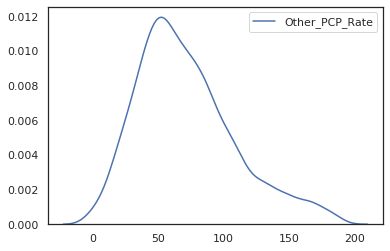

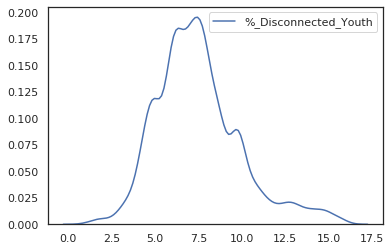

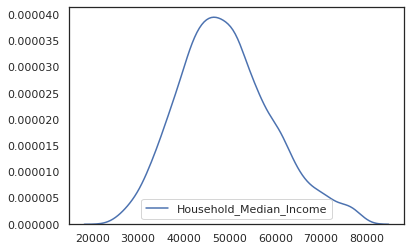

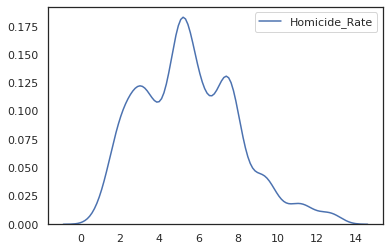

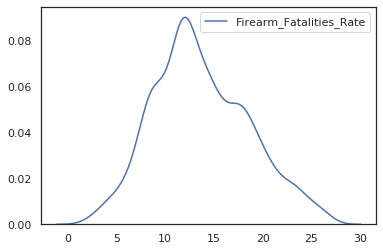

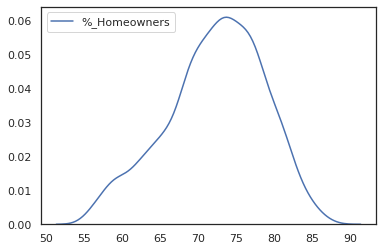

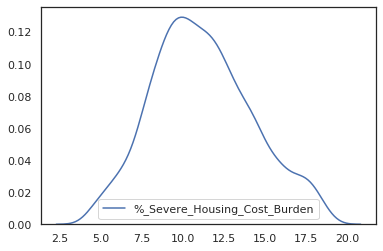

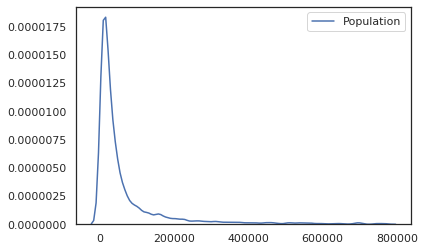

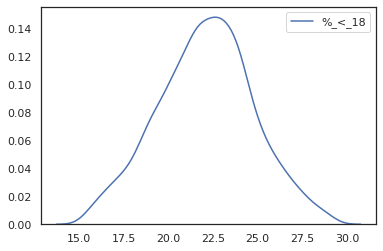

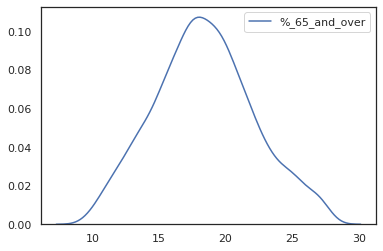

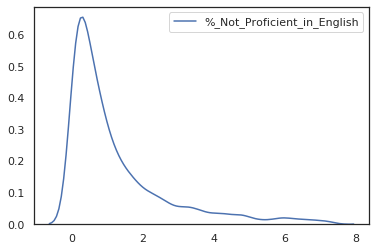

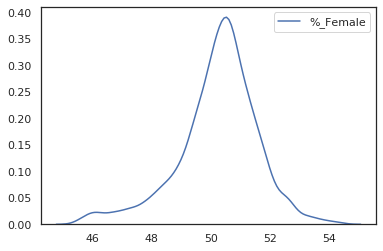

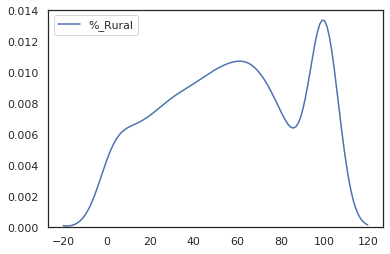

In [5]:
for i, column in enumerate(df.drop(["State"], axis=1).columns):
    plt.figure(i)
    min_x = (df[column].mean()-(2*df[column].std()))
    max_x = (df[column].mean()+(2*df[column].std()))
    sns.kdeplot(df[column], clip=(min_x, max_x))

#### Transform numerical columns using log

/home/locsta/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


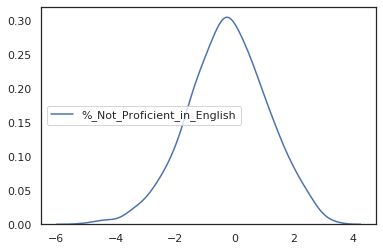

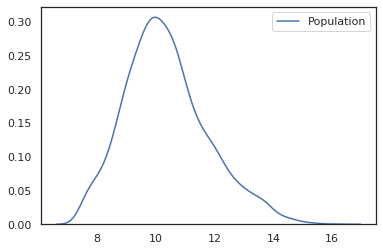

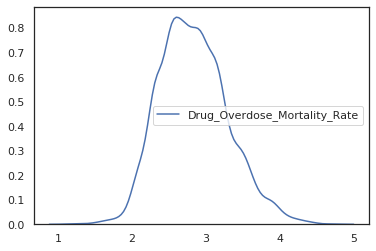

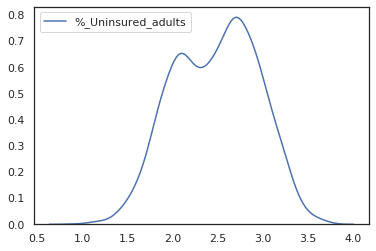

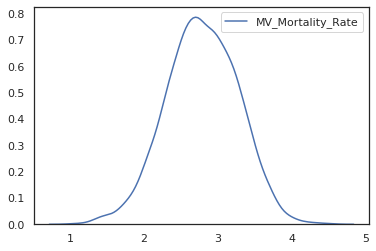

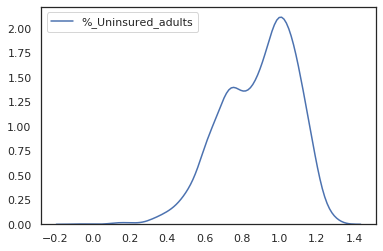

In [6]:
to_log = ["%_Not_Proficient_in_English", "Population" ,"Drug_Overdose_Mortality_Rate", "%_Uninsured_adults","MV_Mortality_Rate", "%_Uninsured_adults"]
# to_categories = ["Other_PCP_Rate","Population", "%_Rural"] #Maybe!
# ["%_Limited_Access_Healthy_Food"]   <= to many std away from mean at the lower end of the tail
for i, column in enumerate(to_log):
    df[column] = df[column].map(lambda x: np.log(x))
    plt.figure(i)
    sns.kdeplot(df[column])

#### Check for normality

In [7]:
#fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

#### Normalize numerical columns

0      -0.18808
1      -0.78853
2       0.18172
3      -0.93052
4       0.62594
5       0.09957
6      -0.33869
7      -0.12673
8      -1.87149
9      -2.33073
10      0.81237
11         -inf
12     -1.62064
13     -0.80350
14     -0.11775
15      0.23013
16     -0.92822
17         -inf
18     -0.61727
19     -0.87064
20      0.27947
21     -0.19936
22     -0.04760
23     -2.39109
24      1.20494
25     -0.27563
26     -0.66054
27      0.18219
28         -inf
29      1.58655
         ...   
3043   -1.67060
3044   -0.63314
3045   -0.38384
3046   -0.25106
3047    0.18880
3048   -0.03100
3049   -0.25489
3050   -0.31503
3051   -0.37040
3052    0.06156
3053    1.09332
3054   -1.99666
3055       -inf
3056   -1.31058
3057    0.29355
3058   -1.72811
3059   -3.29225
3060   -0.15091
3061   -1.94842
3062   -0.03658
3063   -0.95892
3064   -0.32078
3065   -0.13139
3066   -1.42728
3067   -0.67305
3068    0.45922
3069    1.39675
3070   -0.09281
3071   -1.06074
3072   -0.35916
Name: %_Not_Proficient_i

In [9]:
for column in df.columns:
    if column == "State":
        continue
    df[column] = scale(df[column])

ValueError: Input contains infinity or a value too large for dtype('float64').

In [ ]:
df.head()

#### Turn State column into category

In [26]:
df["State"] = df["State"].astype('category')

#### Creating dummy variables

In [27]:
state_dummy = pd.get_dummies(df.State.unique(), drop_first=True)
df = df.drop(["State"], axis=1)
df = pd.concat([df, state_dummy], axis=1)
df.head()

,Life_Expectancy,Child_Mortality_Rate,Infant_Mortality_Rate,%_Frequent_Mental_Distress,%_Diabetic,%_Food_Insecure,%_Limited_Access_Healthy_Food,Drug_Overdose_Mortality_Rate,MV_Mortality_Rate,%_Insufficient_Sleep,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,76.330589,53.279441,7.699275,12.638357,14.2,13.4,11.991125,9.623076,20.377158,35.905406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,78.599498,47.000017,5.851337,12.822558,11.3,12.3,5.424427,16.322612,15.092364,33.305868,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,75.779457,77.080027,8.444680,14.632311,18.0,23.2,10.739667,17.038235,20.966953,38.563167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73.928271,111.749681,14.792899,12.854036,14.9,15.8,2.601627,22.093263,25.272469,38.148865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,74.597767,76.032935,6.184688,13.827943,14.3,11.0,2.880150,24.799585,25.711771,35.945010,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
